In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import json
import cv2
import urllib
import os
#import textract
#import pytesseract
import colorsys
#import deepface
#from deepface import DeepFace

In [20]:
def read_csv(title):
    return pd.read_csv(title, sep=',', encoding='cp1252', engine='python')

def transform_df(df):
    del df['Unnamed: 0']
    df['comments_disabled'] = df['comments_disabled'].transform(lambda x: 0 if x=='False' else 1)
    df['ratings_disabled'] = df['ratings_disabled'].transform(lambda x: 0 if x=='False' else 1)
    return df

def get_category(df, file_name):
    categories_dict = {}
    with open(file_name) as file:
        cats = json.load(file)
        for x in cats['items']:
            categories_dict[x['id']] = x['snippet']['title']

    df['category_name'] = df['categoryId'].transform(lambda x: "Unknown" if x=='False' or not x or pd.isna(x) or str(int(float(x))) not in categories_dict else categories_dict[str(int(float(x)))])
    return df

def symbolic_transformer(df, name):
    return df['title'].transform(lambda x: len([y for y in x if y==name]) if x else 0)

def transform_df_symbols_and_title_nuissances(df):
    df['title_length'] = df['title'].transform(lambda x: None if x is None else len(x))
    df['description_length'] = df['description'].transform(lambda x: 0 if not x else len(str(x)))
    df['nr_tags'] = df['tags'].transform(lambda x: 0 if x is None or x=='[None]' else len(x.split('|')))
    df['link_amount'] = df['description'].transform(lambda x: 0 if not x else str(x).count('://'))
    
    df['interpunction_title'] = df['title'].transform(lambda x: len([y for y in x if y in [',', ';', '`', "'", '"', '.', '!', '?', ':']]) if x else 0)
    df['interpunction_exclamation'] = symbolic_transformer(df, '!')
    df['interpunction_question'] = symbolic_transformer(df, '?')
    df['interpunction_dot'] = symbolic_transformer(df, '.')
    df['interpunction_comma'] = symbolic_transformer(df, ',')
    
    df['screams'] = df['title'].transform(lambda x: len([y for y in x if ord(y)>=65 and ord(y)<=90]) if x else 0)
    df['screams_to_normal_proportion'] = df['title'].transform(lambda x: len([y for y in x if ord(y)>=65 and ord(y)<=90])/len(x) if x else 0)
    return df

def transform_dates(df):
    day_const = (3600*24)
    df['publishedAt_modern'] = df['publishedAt'].transform(lambda x: None if (not x or len(x)<8) else datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
    df['trending_date_modern'] = df['trending_date'].transform(lambda x: None if (not x or len(x)<8) else datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
    
    df['weekday_published'] = df['publishedAt_modern'].transform(lambda x: x.weekday())
    df['time_diff'] = (df['trending_date_modern']-df['publishedAt_modern']).transform(lambda x:x.total_seconds()/(day_const))
    return df

In [21]:
US95 = read_csv('USdata95.csv')
GB95 = read_csv('GBdata95.csv')

primal_gb = [GB95]
primal_us = [US95]
primal_gb = [get_category(x, 'GB_category_id.json') for x in primal_gb]
primal_us = [get_category(x, 'US_category_id.json') for x in primal_us]

elements = [*primal_gb]
elements.extend(primal_us)
elements = [transform_df(x) for x in elements]


elements = [transform_df_symbols_and_title_nuissances(x) for x in elements]
elements = [transform_dates(x) for x in elements]
all_movies = pd.concat(elements)
post_movies = all_movies.copy()
neo_movies = post_movies.sort_values(by='trending_date_modern').drop_duplicates(subset=['video_id'])

In [22]:
amount = 1000
download = True

In [23]:
if download:
    for i, x in enumerate(neo_movies['thumbnail_link'][:amount]):
        try:
            urllib.request.urlretrieve(x, f'./images/file_{i}.jpg')
        except:
            print(f'Unable to show image nr {i}')
            pass

Unable to show image nr 95
Unable to show image nr 107
Unable to show image nr 108
Unable to show image nr 241
Unable to show image nr 259
Unable to show image nr 311
Unable to show image nr 318
Unable to show image nr 451
Unable to show image nr 469
Unable to show image nr 486
Unable to show image nr 506
Unable to show image nr 510
Unable to show image nr 587
Unable to show image nr 594
Unable to show image nr 711
Unable to show image nr 716
Unable to show image nr 767
Unable to show image nr 778
Unable to show image nr 803
Unable to show image nr 867
Unable to show image nr 887
Unable to show image nr 908
Unable to show image nr 917
Unable to show image nr 924
Unable to show image nr 951
Unable to show image nr 952
Unable to show image nr 965
Unable to show image nr 973
Unable to show image nr 976


In [27]:
images = [cv2.imread(f'./images/file_{i}.jpg', cv2.IMREAD_COLOR)[...,::-1] for i in range(amount) if os.path.exists(f'./images/file_{i}.jpg')]

In [28]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [29]:
def do_all_steps_face(images):
    x_size, y_size=2, 10
    fig, ax=plt.subplots(y_size, x_size, figsize=(x_size*18, y_size*18))

    amount_faces=[]
    for i, img in enumerate(images):
        img = images[i]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.06,
            minNeighbors=2,
            flags=cv2.CASCADE_SCALE_IMAGE
        )

        if i<y_size*x_size:
            for (x, y, w, h) in faces: 
                cv2.rectangle(gray, (x, y), (x+w, y+h), (255, 255, 255), 3)
                face = img[x:x+w,y:y+h]
            ax[i//x_size][i%x_size].imshow(gray, cmap="gray")
        amount_faces.append(len(faces))
    plt.show()
    
    
    mx_af = max(amount_faces)
    count_amount_faces = [0]*(mx_af+1)
    for x in amount_faces:
        count_amount_faces[x] += 1
        
    fig, ax = plt.subplots(1, 1, figsize=(18,18))
    ax.bar(list(range(mx_af+1)), count_amount_faces)
    ax.set_title('Amount of (frontal) faces in thumbnails')
    plt.show()

In [30]:
def do_all_steps_canny(images):
    x_size, y_size=2, 10
    fig, ax=plt.subplots(y_size, x_size, figsize=(x_size*18, y_size*18))
    amount_action = []
    
    for i, img in enumerate(images):
        img_edge = cv2.Canny(img,100,200)
        
        if i<y_size*x_size:
            ax[i//x_size][i%x_size].imshow(img_edge, cmap="gray")
            
        summa = sum([sum(x) for x in img_edge])//255
        amount_action.append(summa/(img_edge.shape[0]*img_edge.shape[1]))
        
    fig, ax = plt.subplots(1, 1, figsize=(18,18))
    ax.hist(amount_action)
    ax.set_title('Amount of action - defined as percentage of edges - in thumbnails')
    plt.show()
    
    #Show least contrastful image
    mn = min(amount_action)
    min_img = [i for i,x in enumerate(amount_action) if x==mn][0]
    plt.imshow(images[min_img])
    plt.show()

In [31]:
def linearize_color(color):
    linear = []
    for x in color:
        linear.extend(x)
    linear = sorted(linear)
    return linear

def do_all_steps_color_palette(images, cols):
    mean_color = [[], [], []]
    std_color = [[], [], []]
    for img in images:
        colors = [img[:,:,i] for i in range(3)]
        linear = [linearize_color(colors[i]) for i in range(3)]
        _ = [mean_color[i].append(sum(linear[i])/len(linear[i])) for i in range(3)]
        _ = [std_color[i].append(np.std(linear[i])) for i in range(3)]
        
    fig, ax = plt.subplots(3, 2, figsize=(2*18,3*18))
    #cols = {0:'blue', 1:'green', 2:'red'}

    for i in range(3):
        ax[i][0].hist(mean_color[i])
        ax[i][0].set_title(f'Mean from color: {cols[i]}')
        
        ax[i][1].hist(std_color[i])
        ax[i][1].set_title(f'Standard deviation from color: {cols[i]}')
    plt.show()

In [32]:
def do_everything(images):
    do_all_steps_face(images)
    do_all_steps_canny(images)
    do_all_steps_color_palette(images, {0:'red', 1:'green', 2:'blue'})
    
    hsv_images = [np.asarray([[colorsys.rgb_to_hsv(*[z/255 for z in x]) for x in y] for y in img]) for img in images]
    do_all_steps_color_palette(hsv_images, {0:'hue', 1:'saturation', 2:'value'})

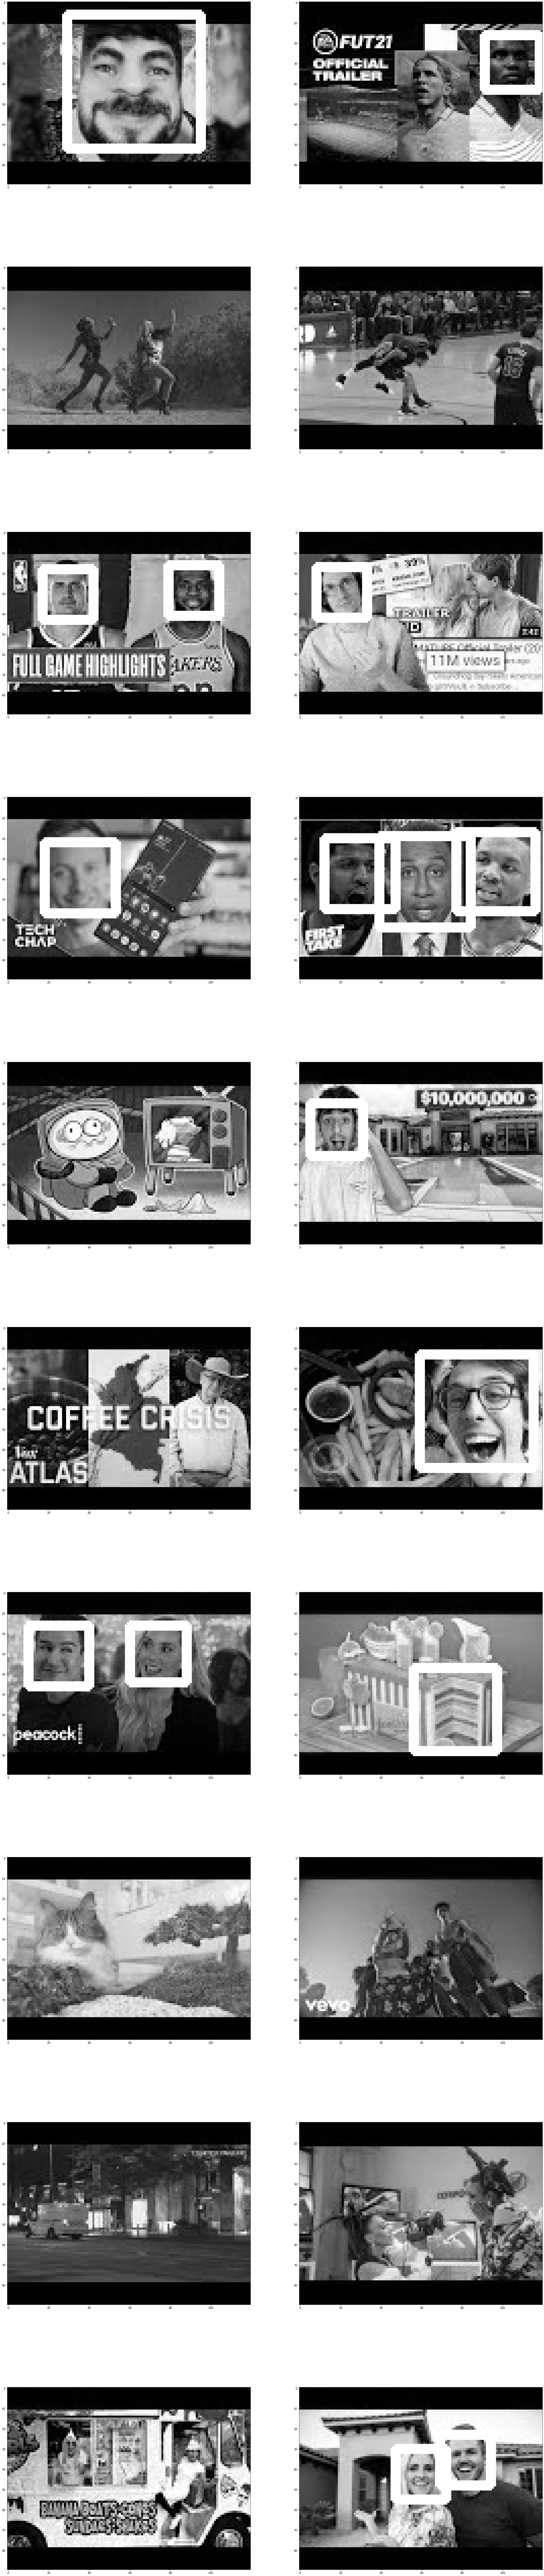

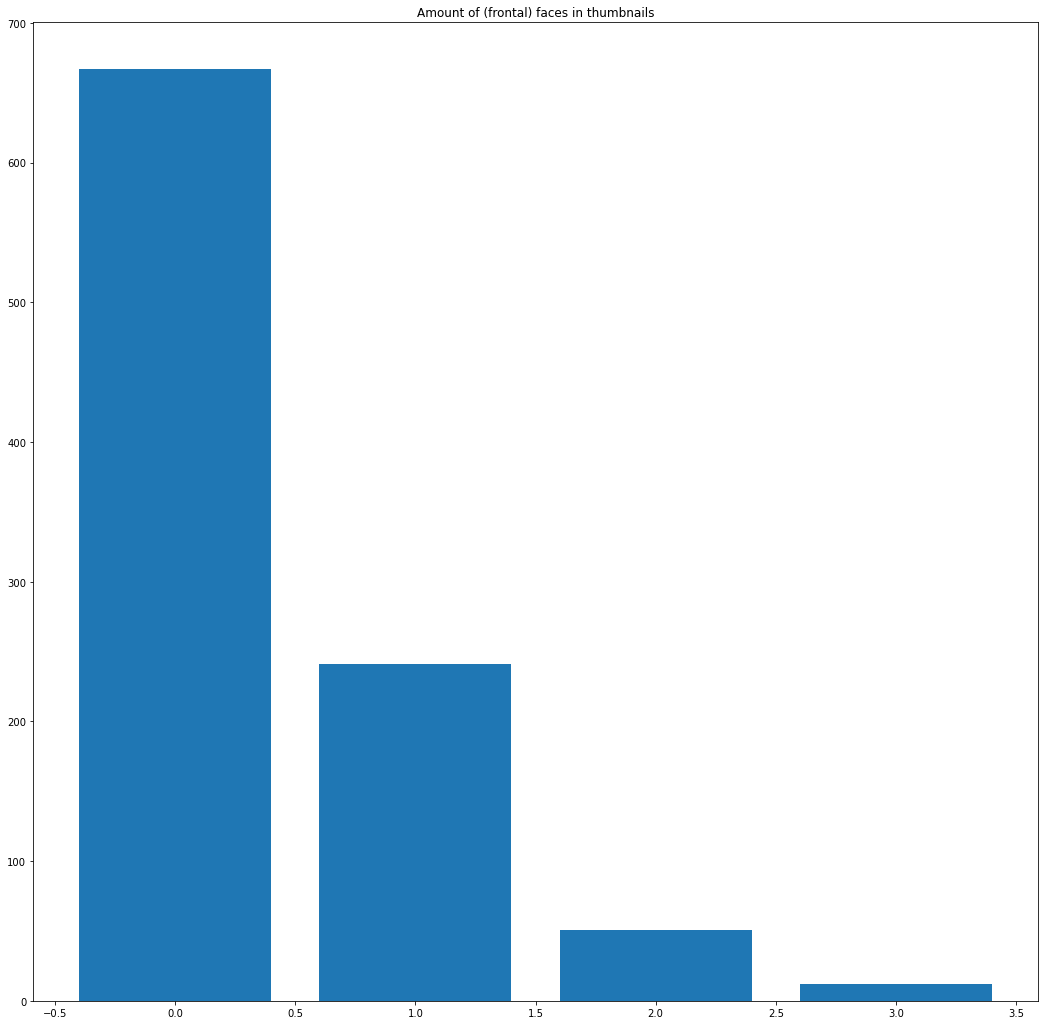

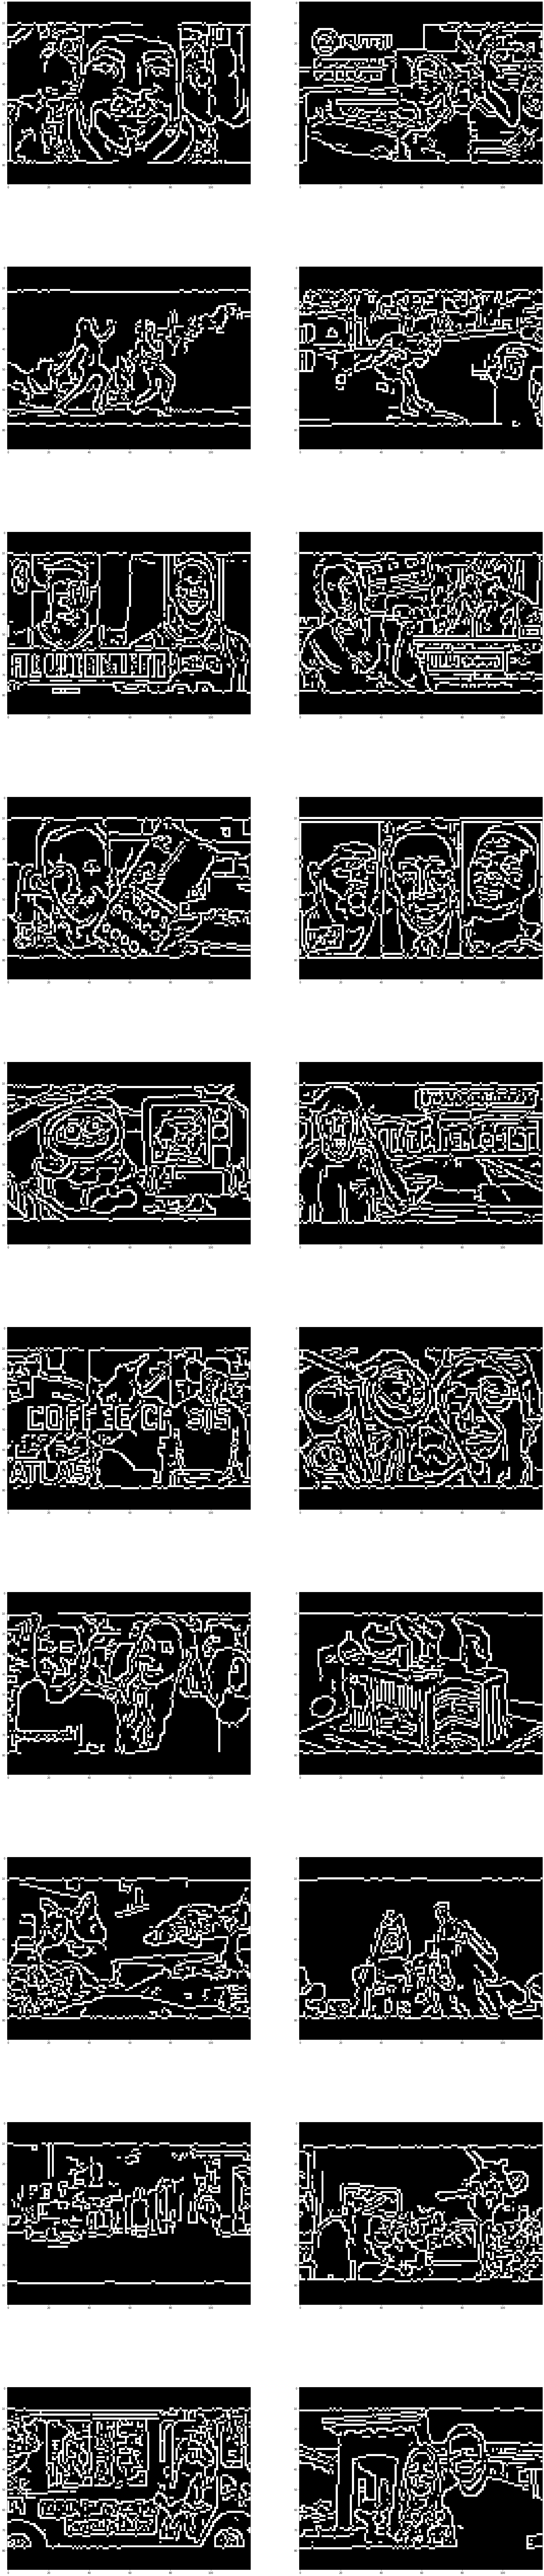

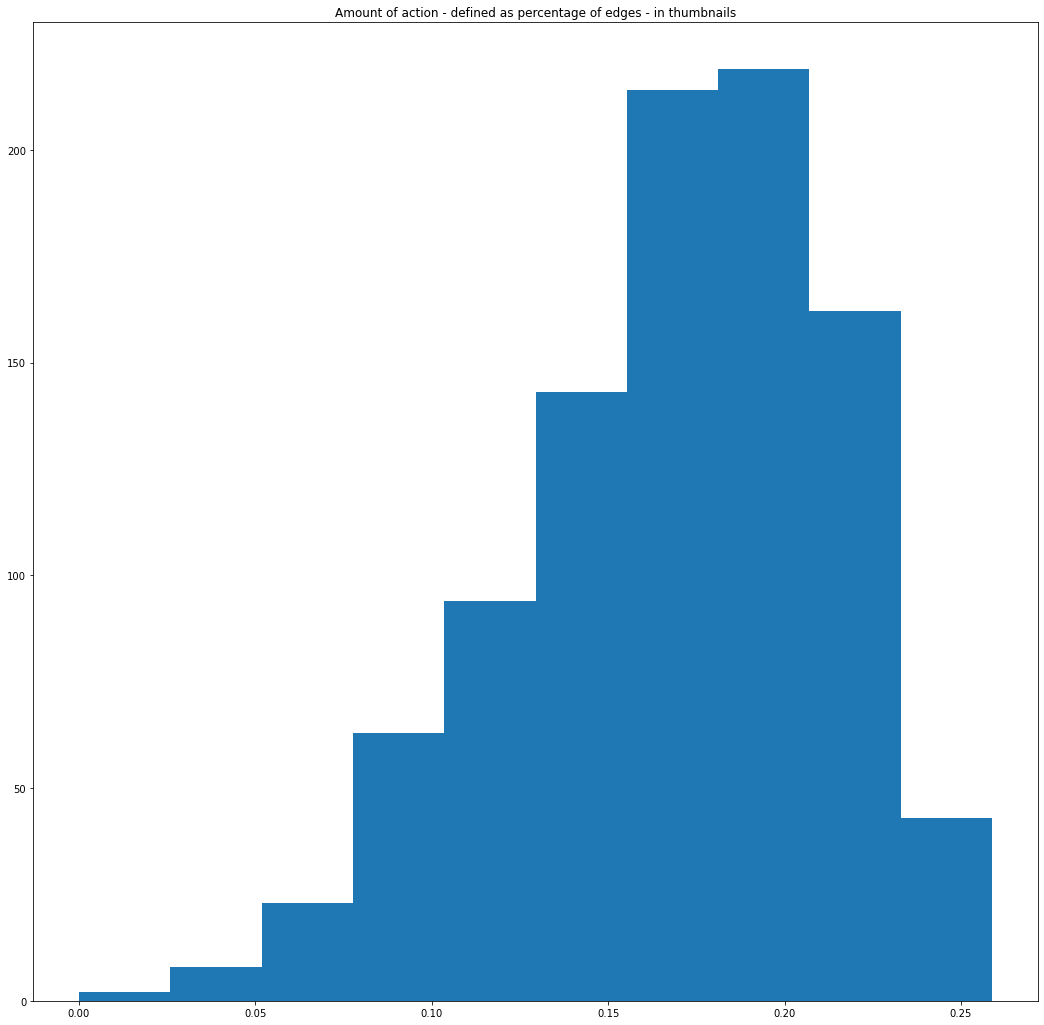

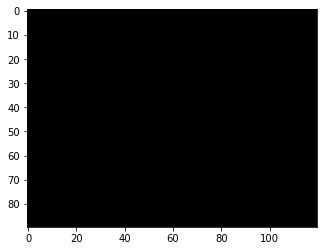

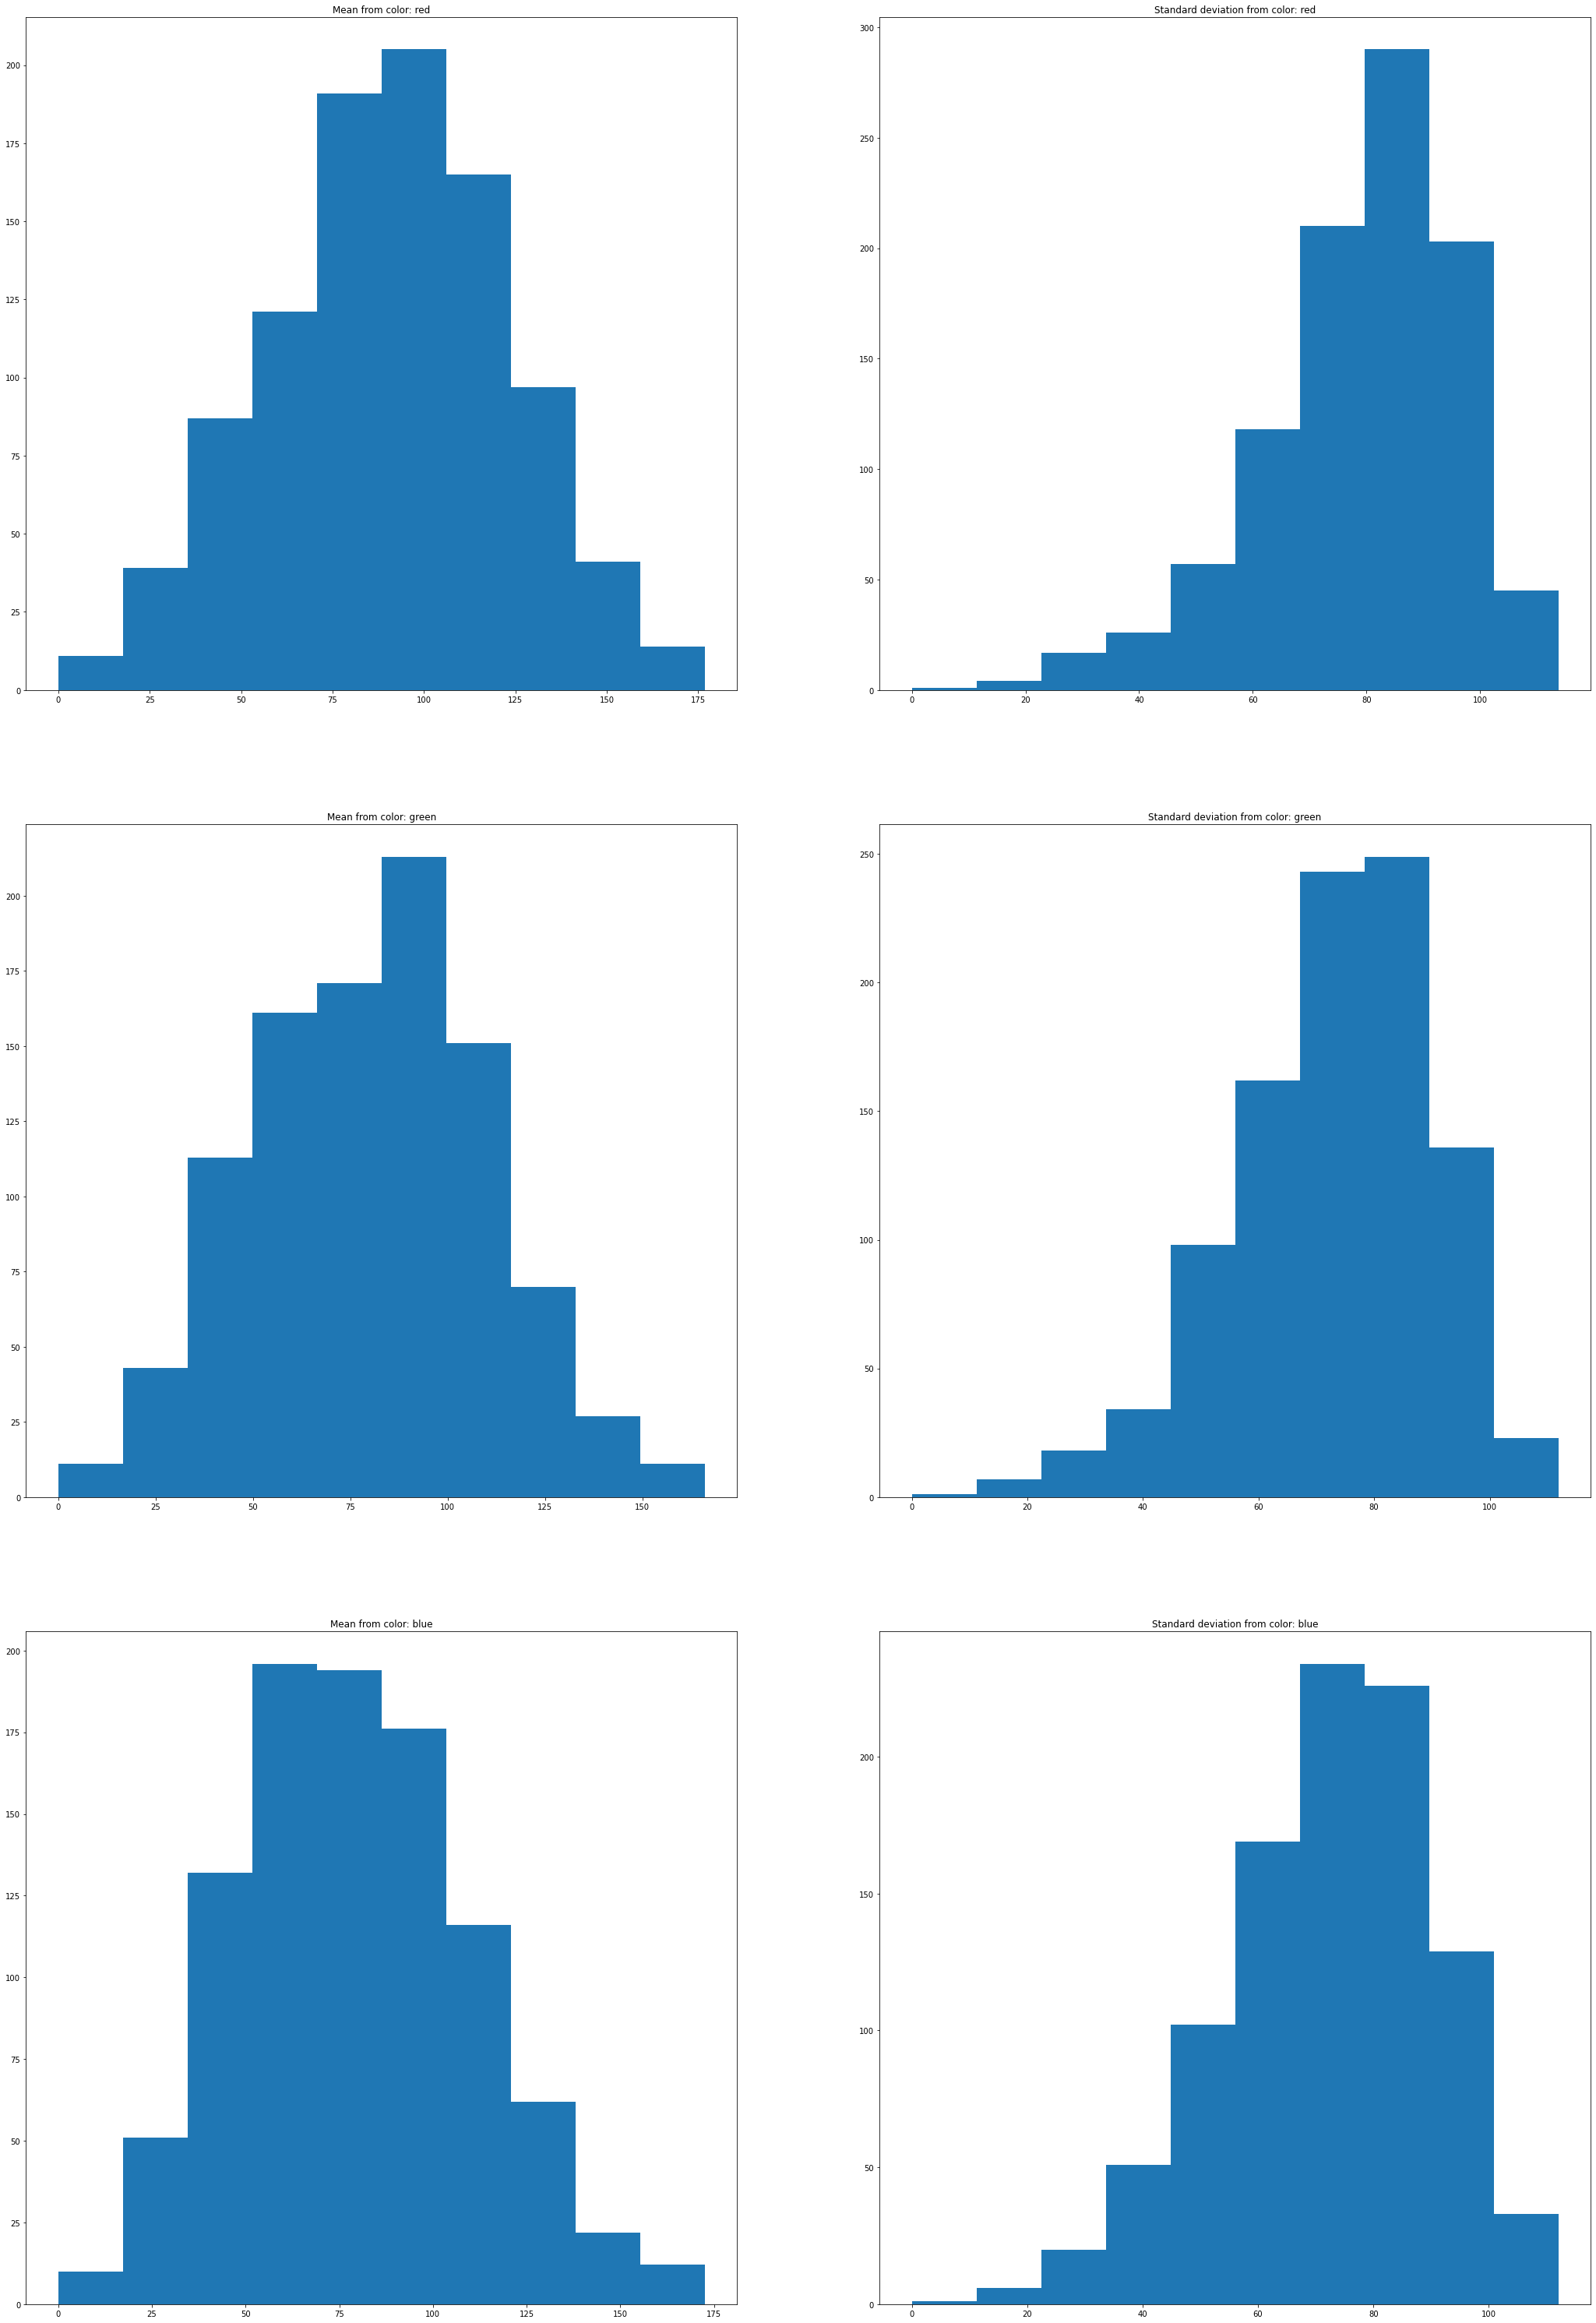

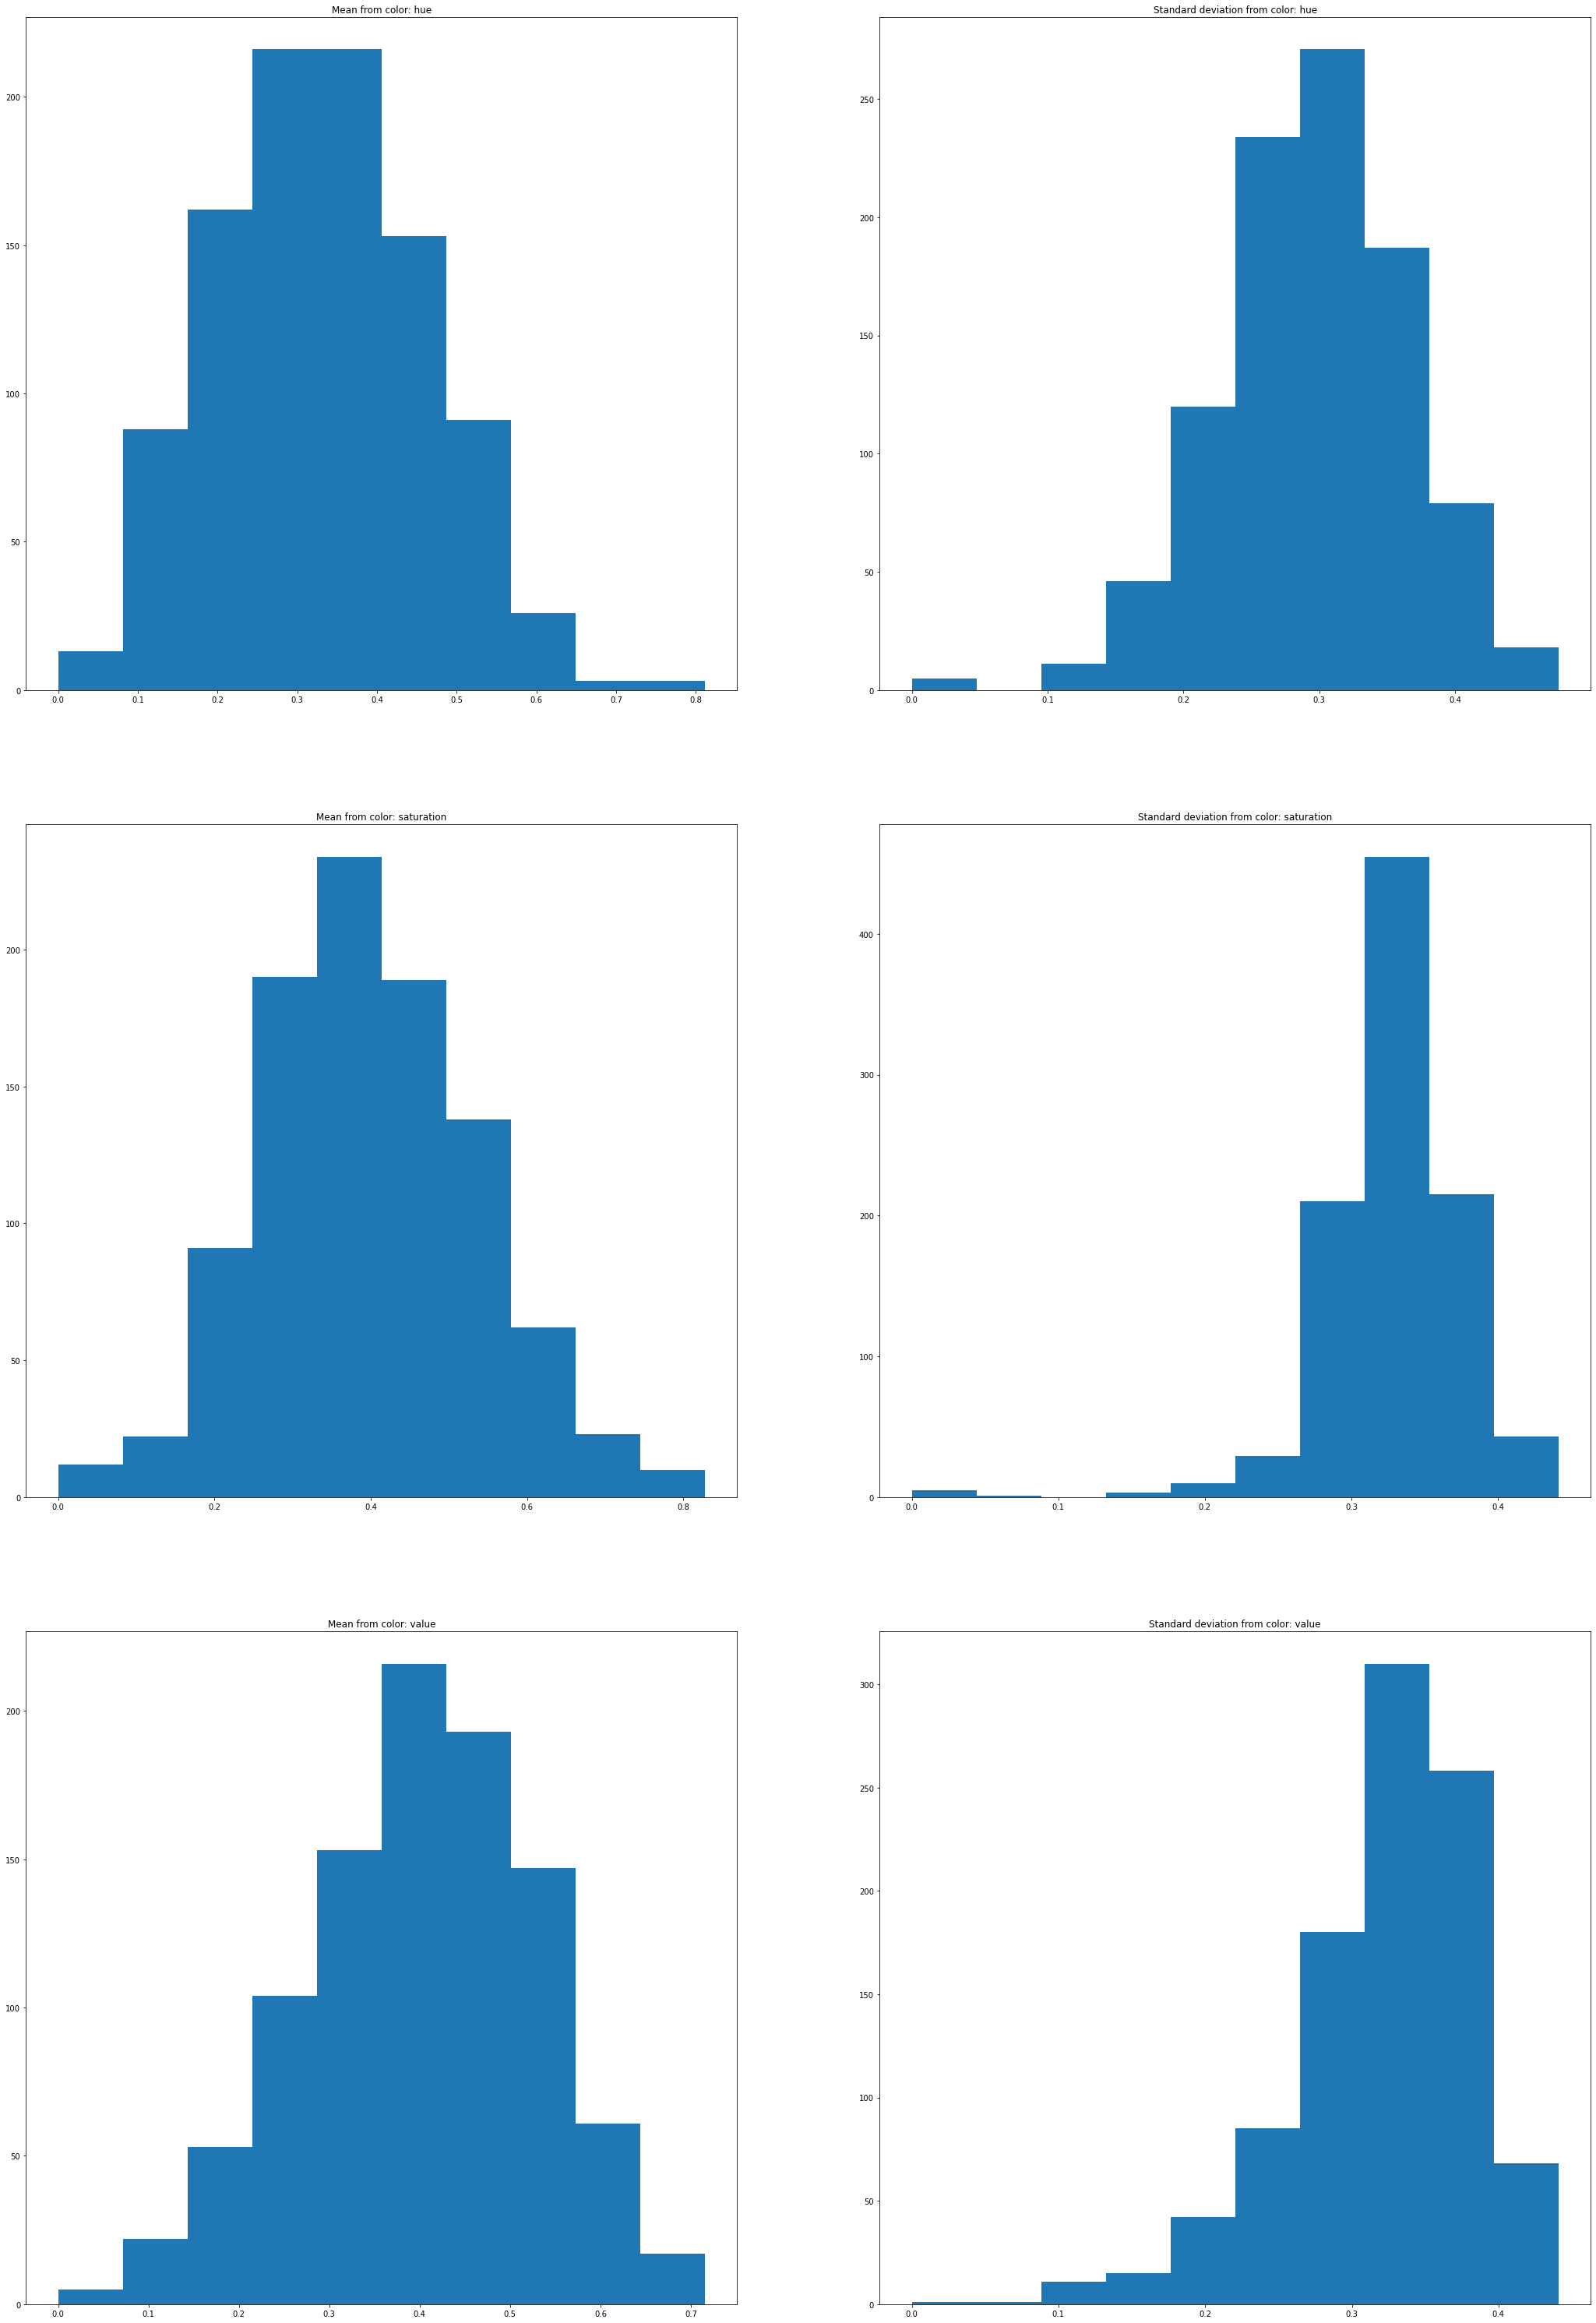

In [33]:
do_everything(images)

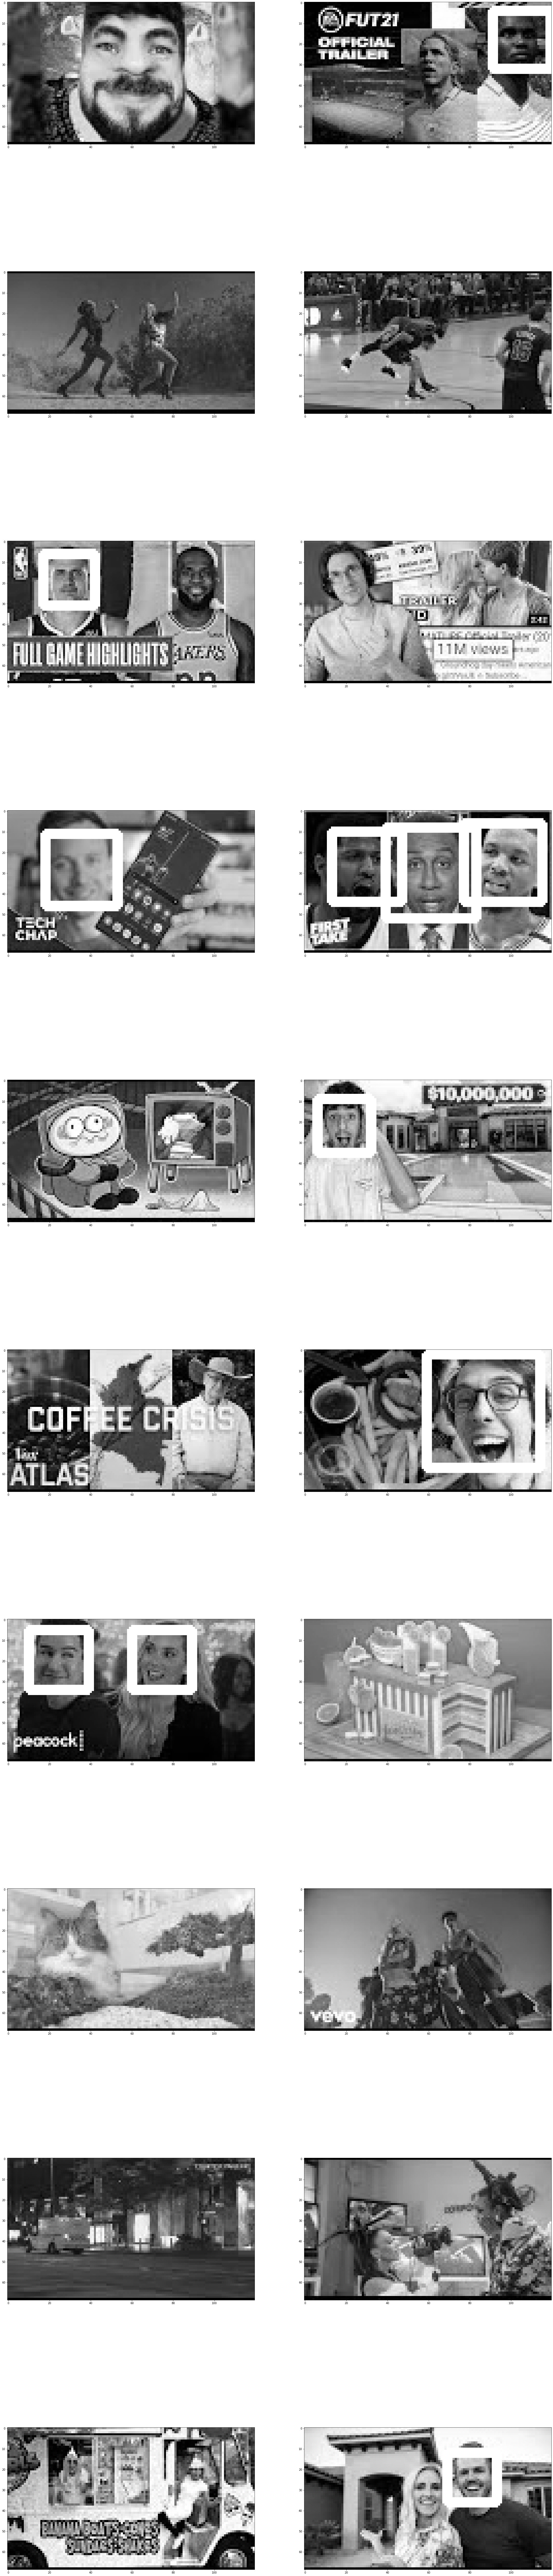

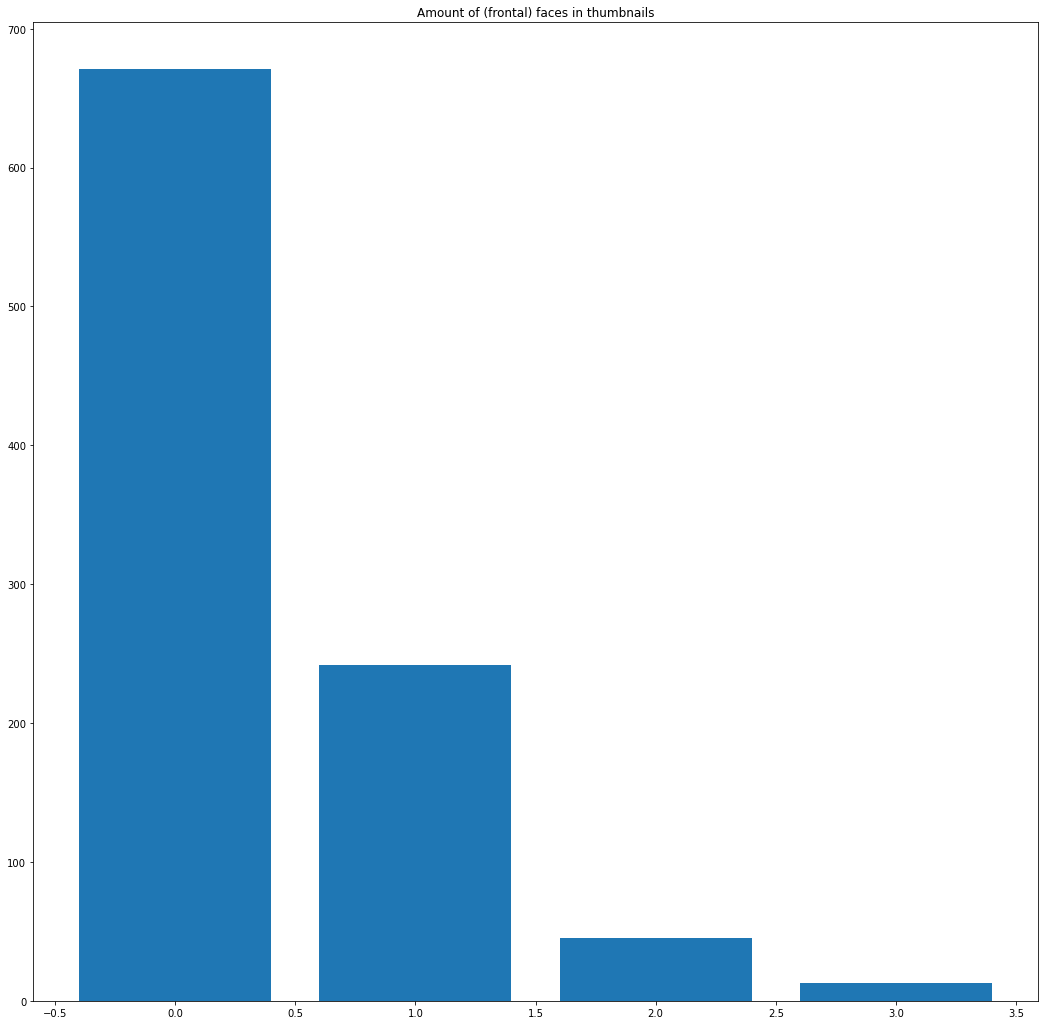

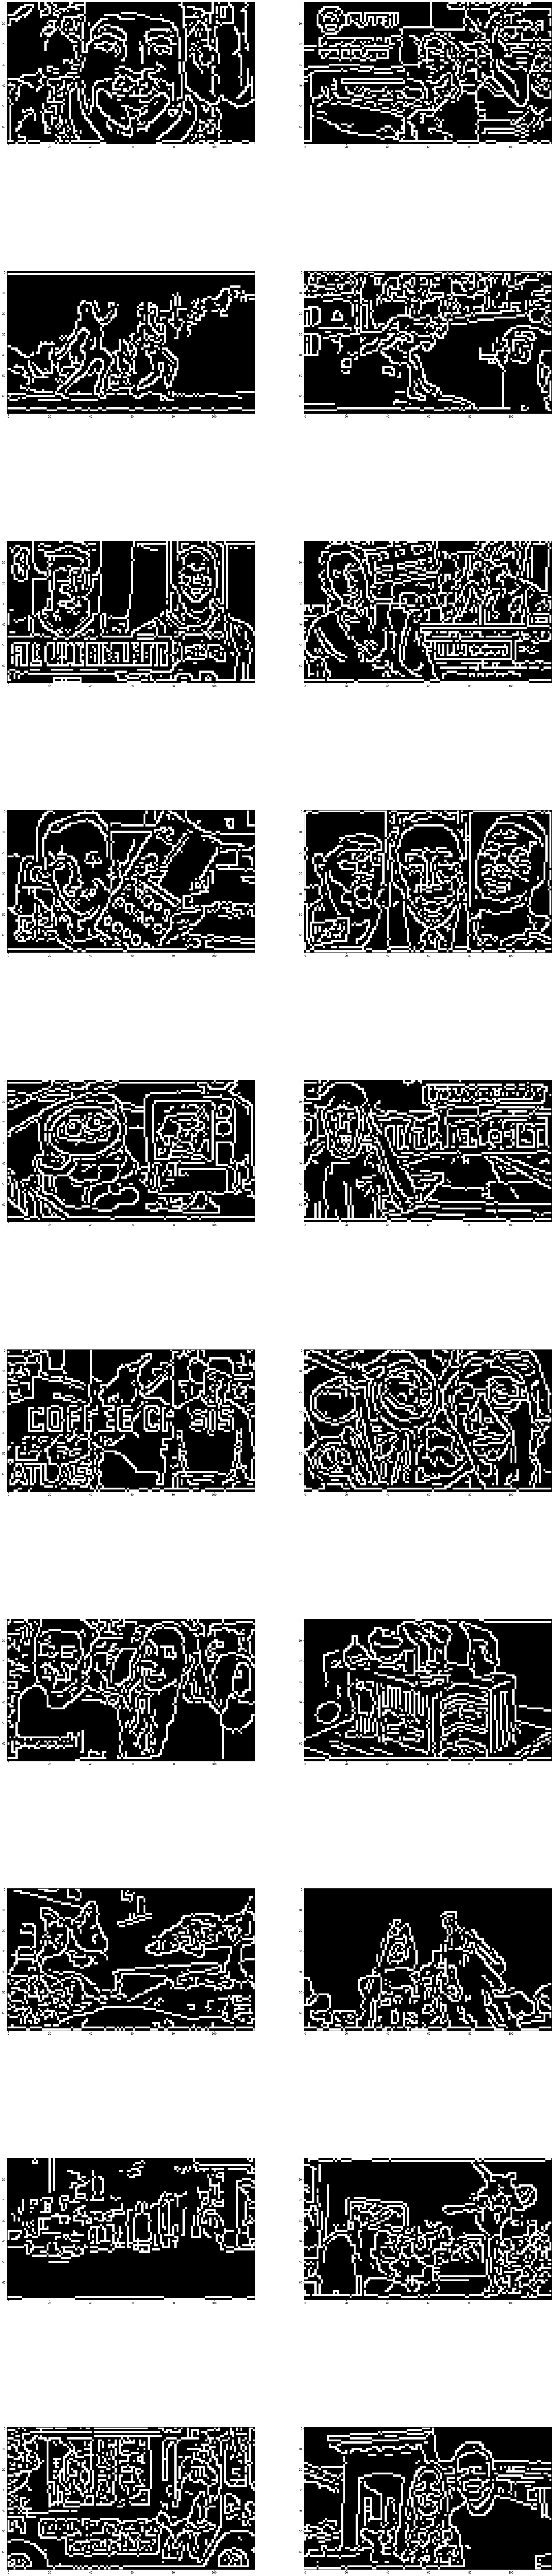

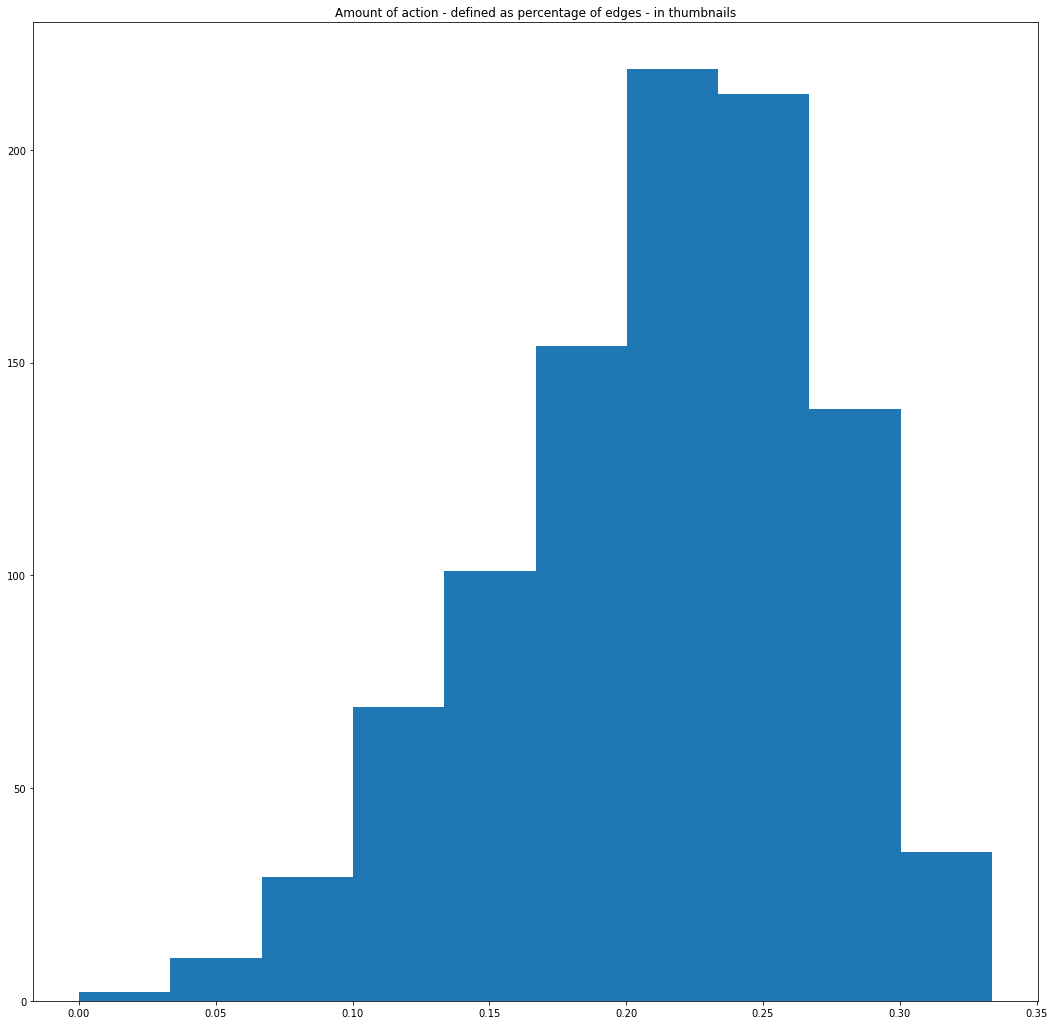

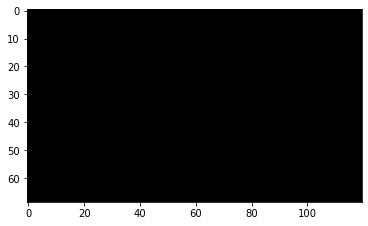

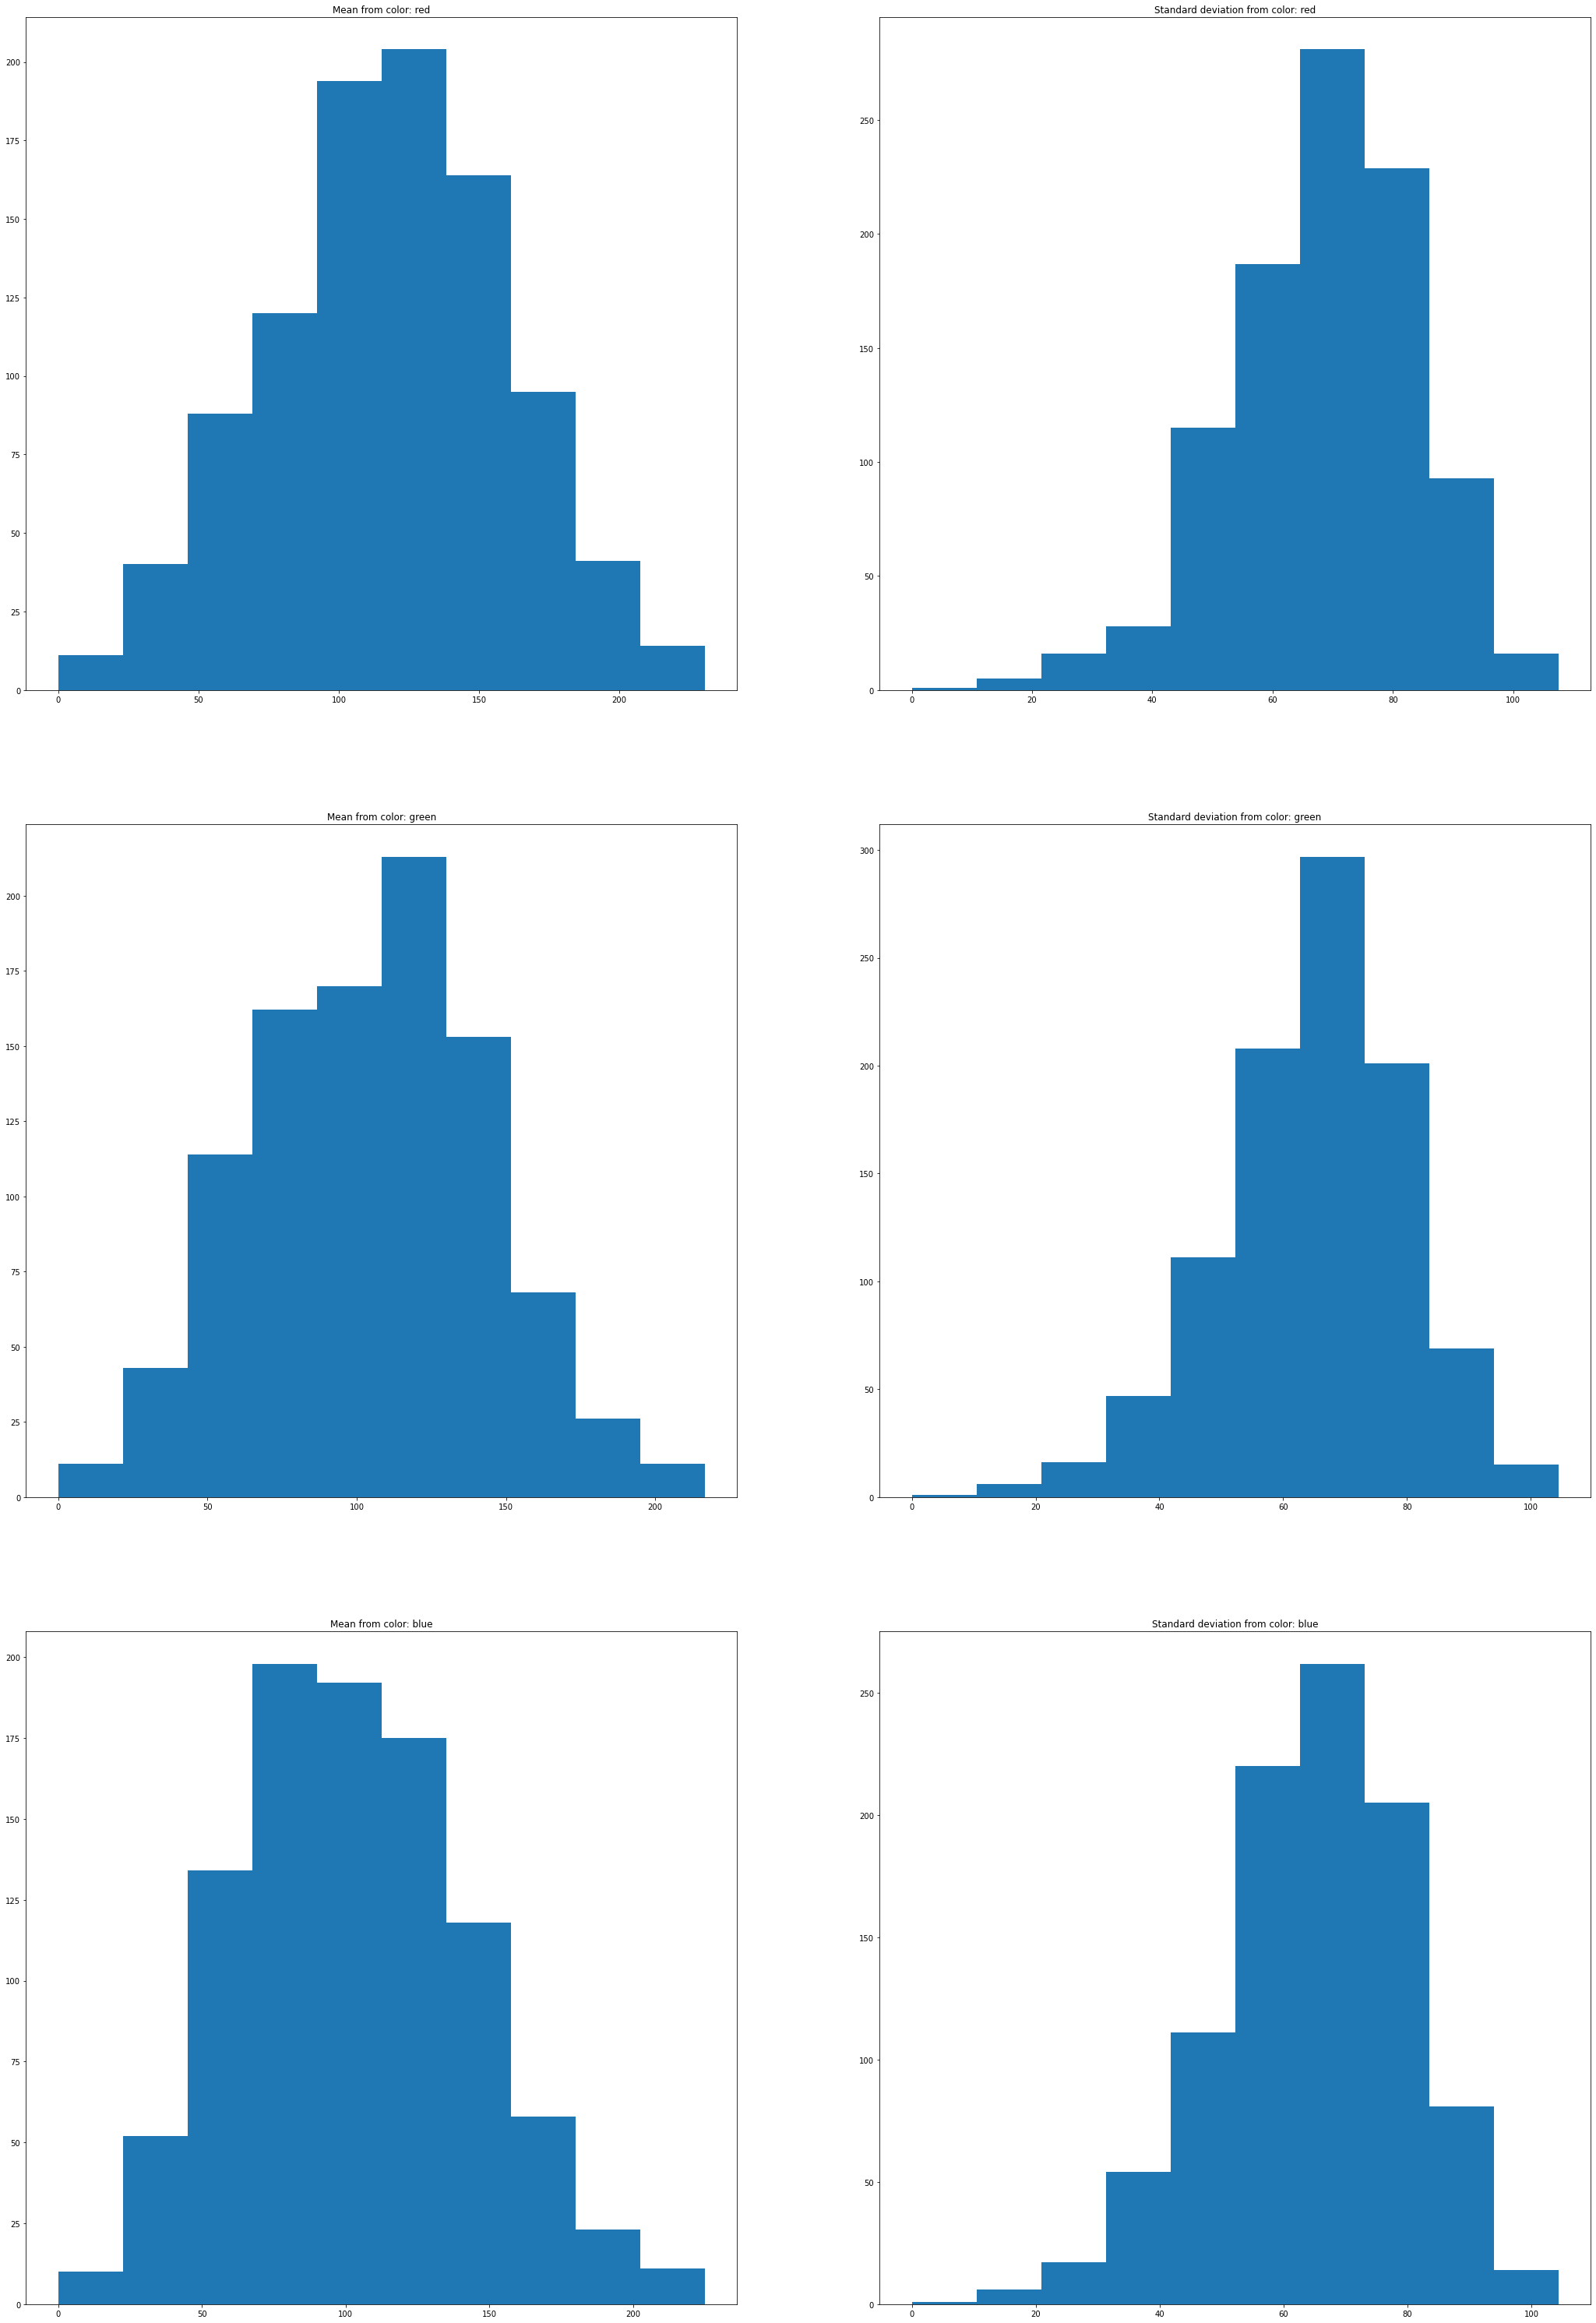

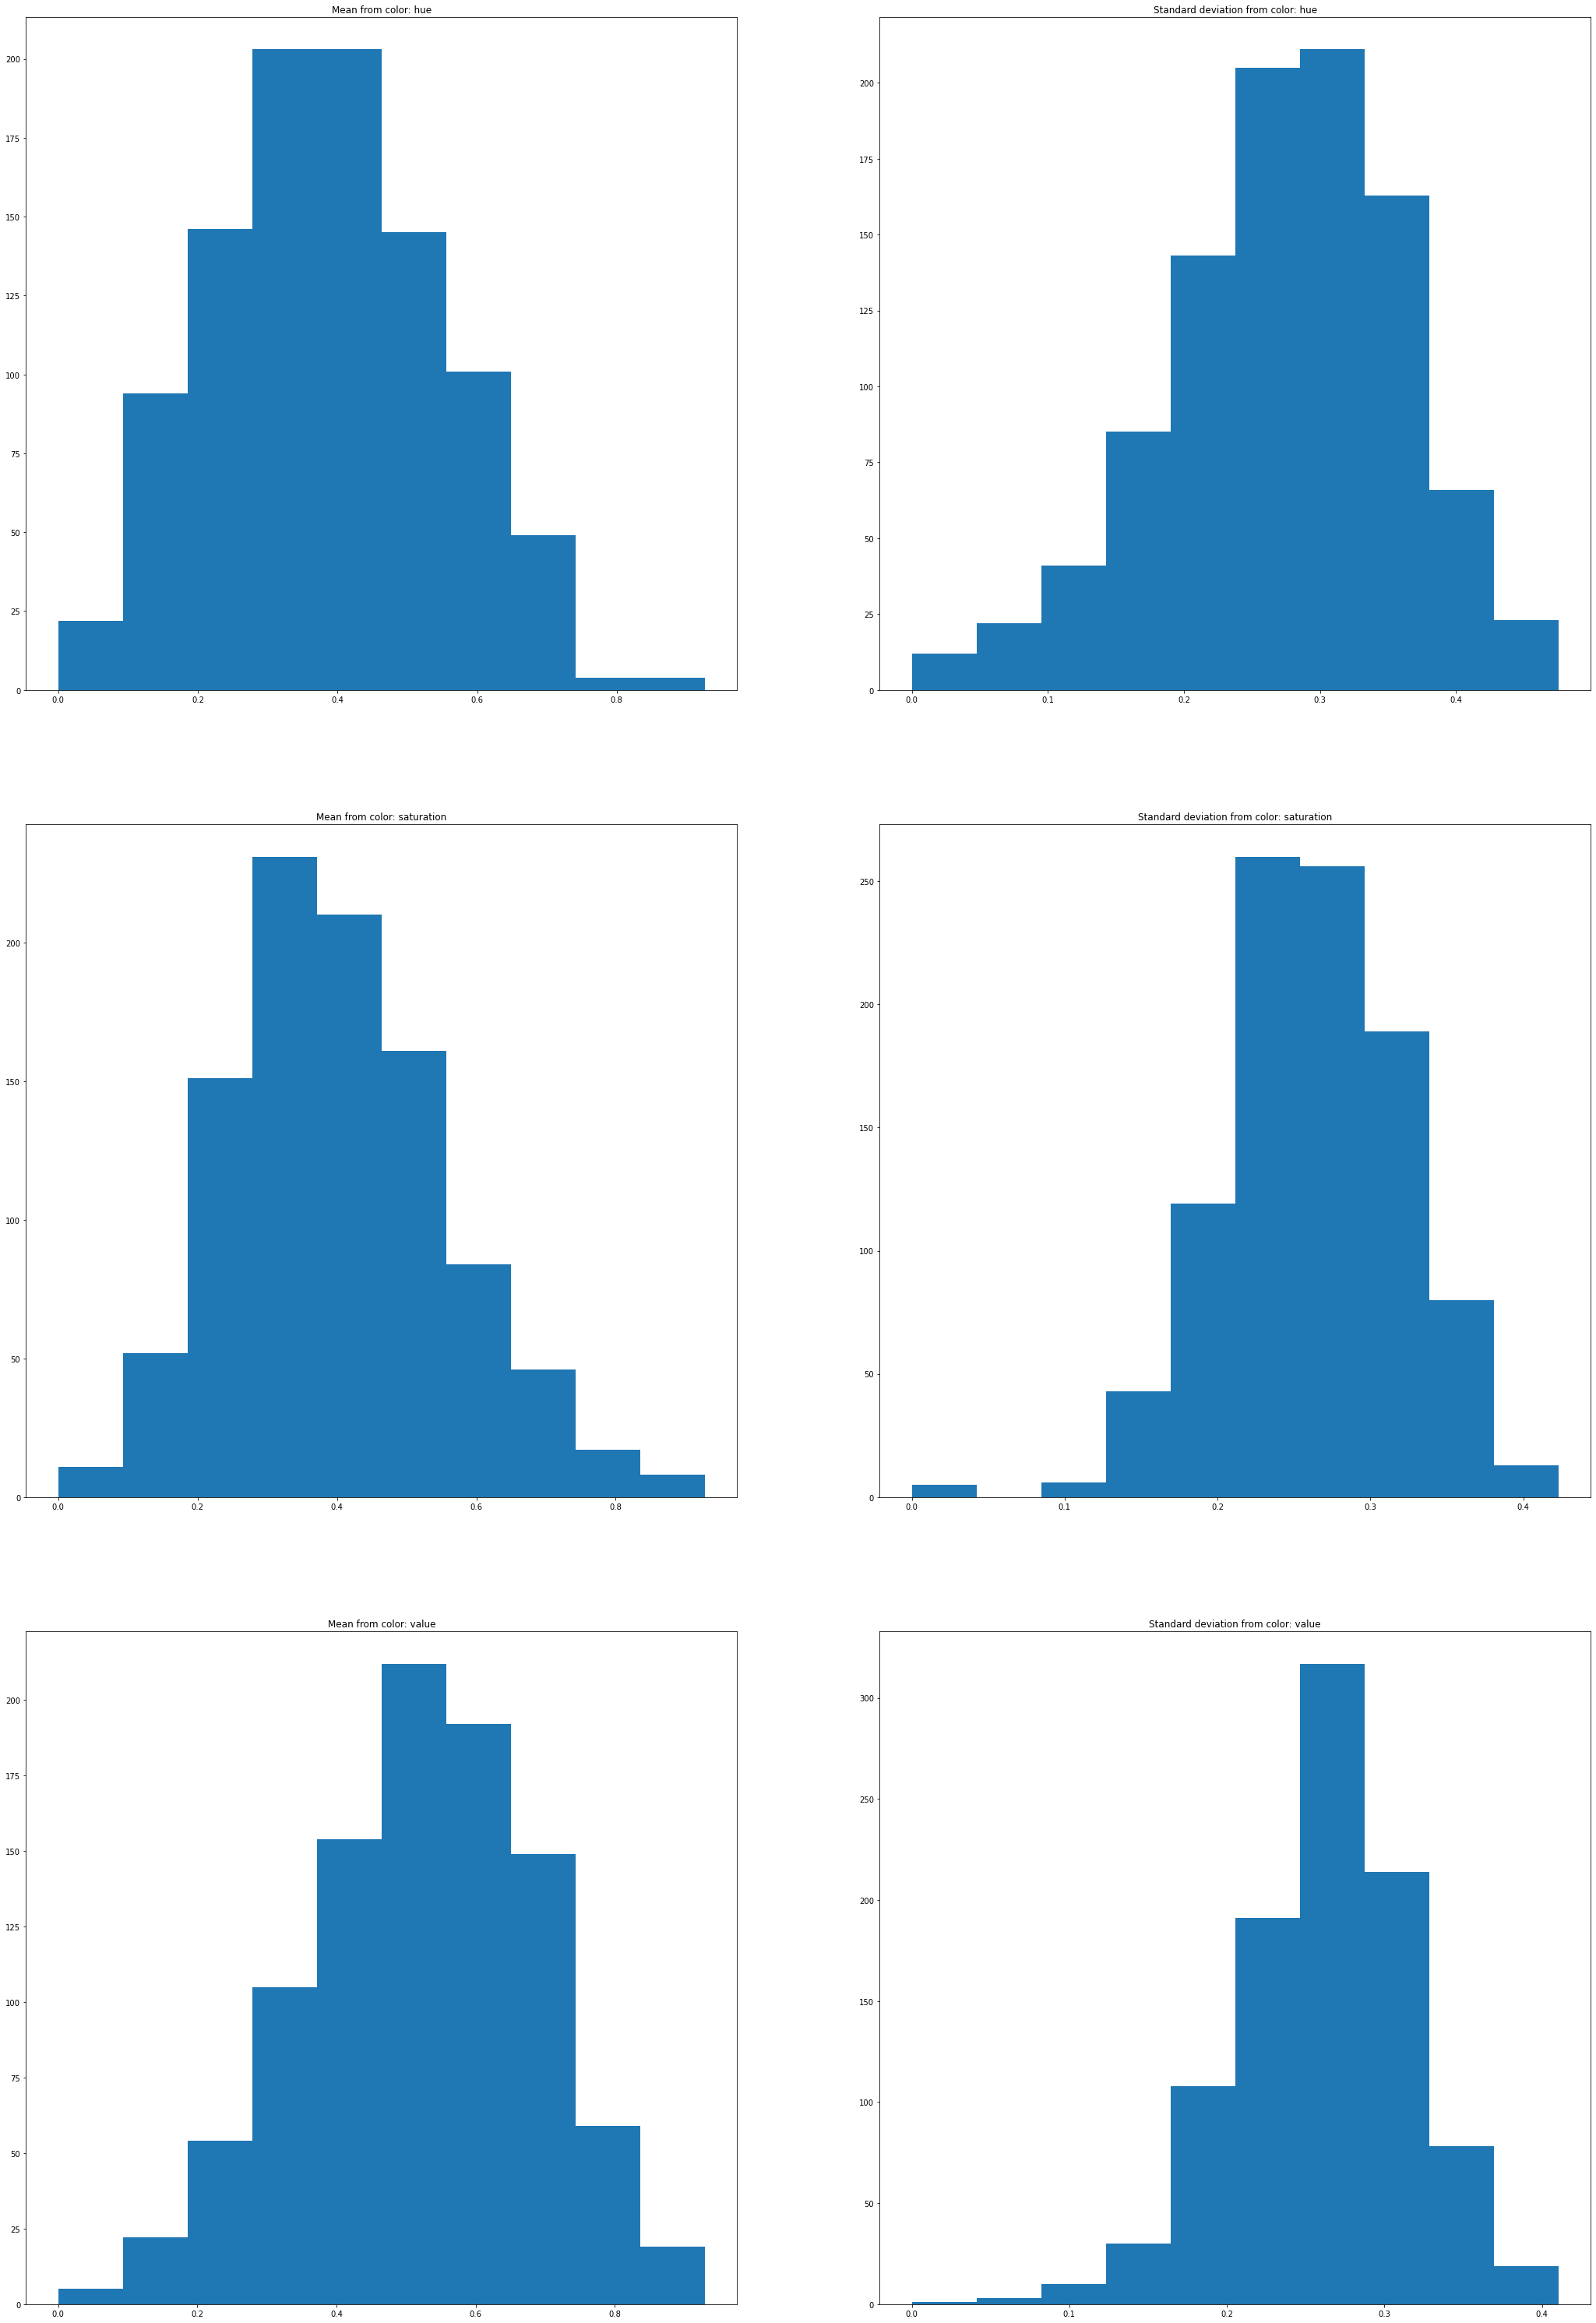

In [34]:
new_images = [img[11:80] for img in images]
do_everything(new_images)

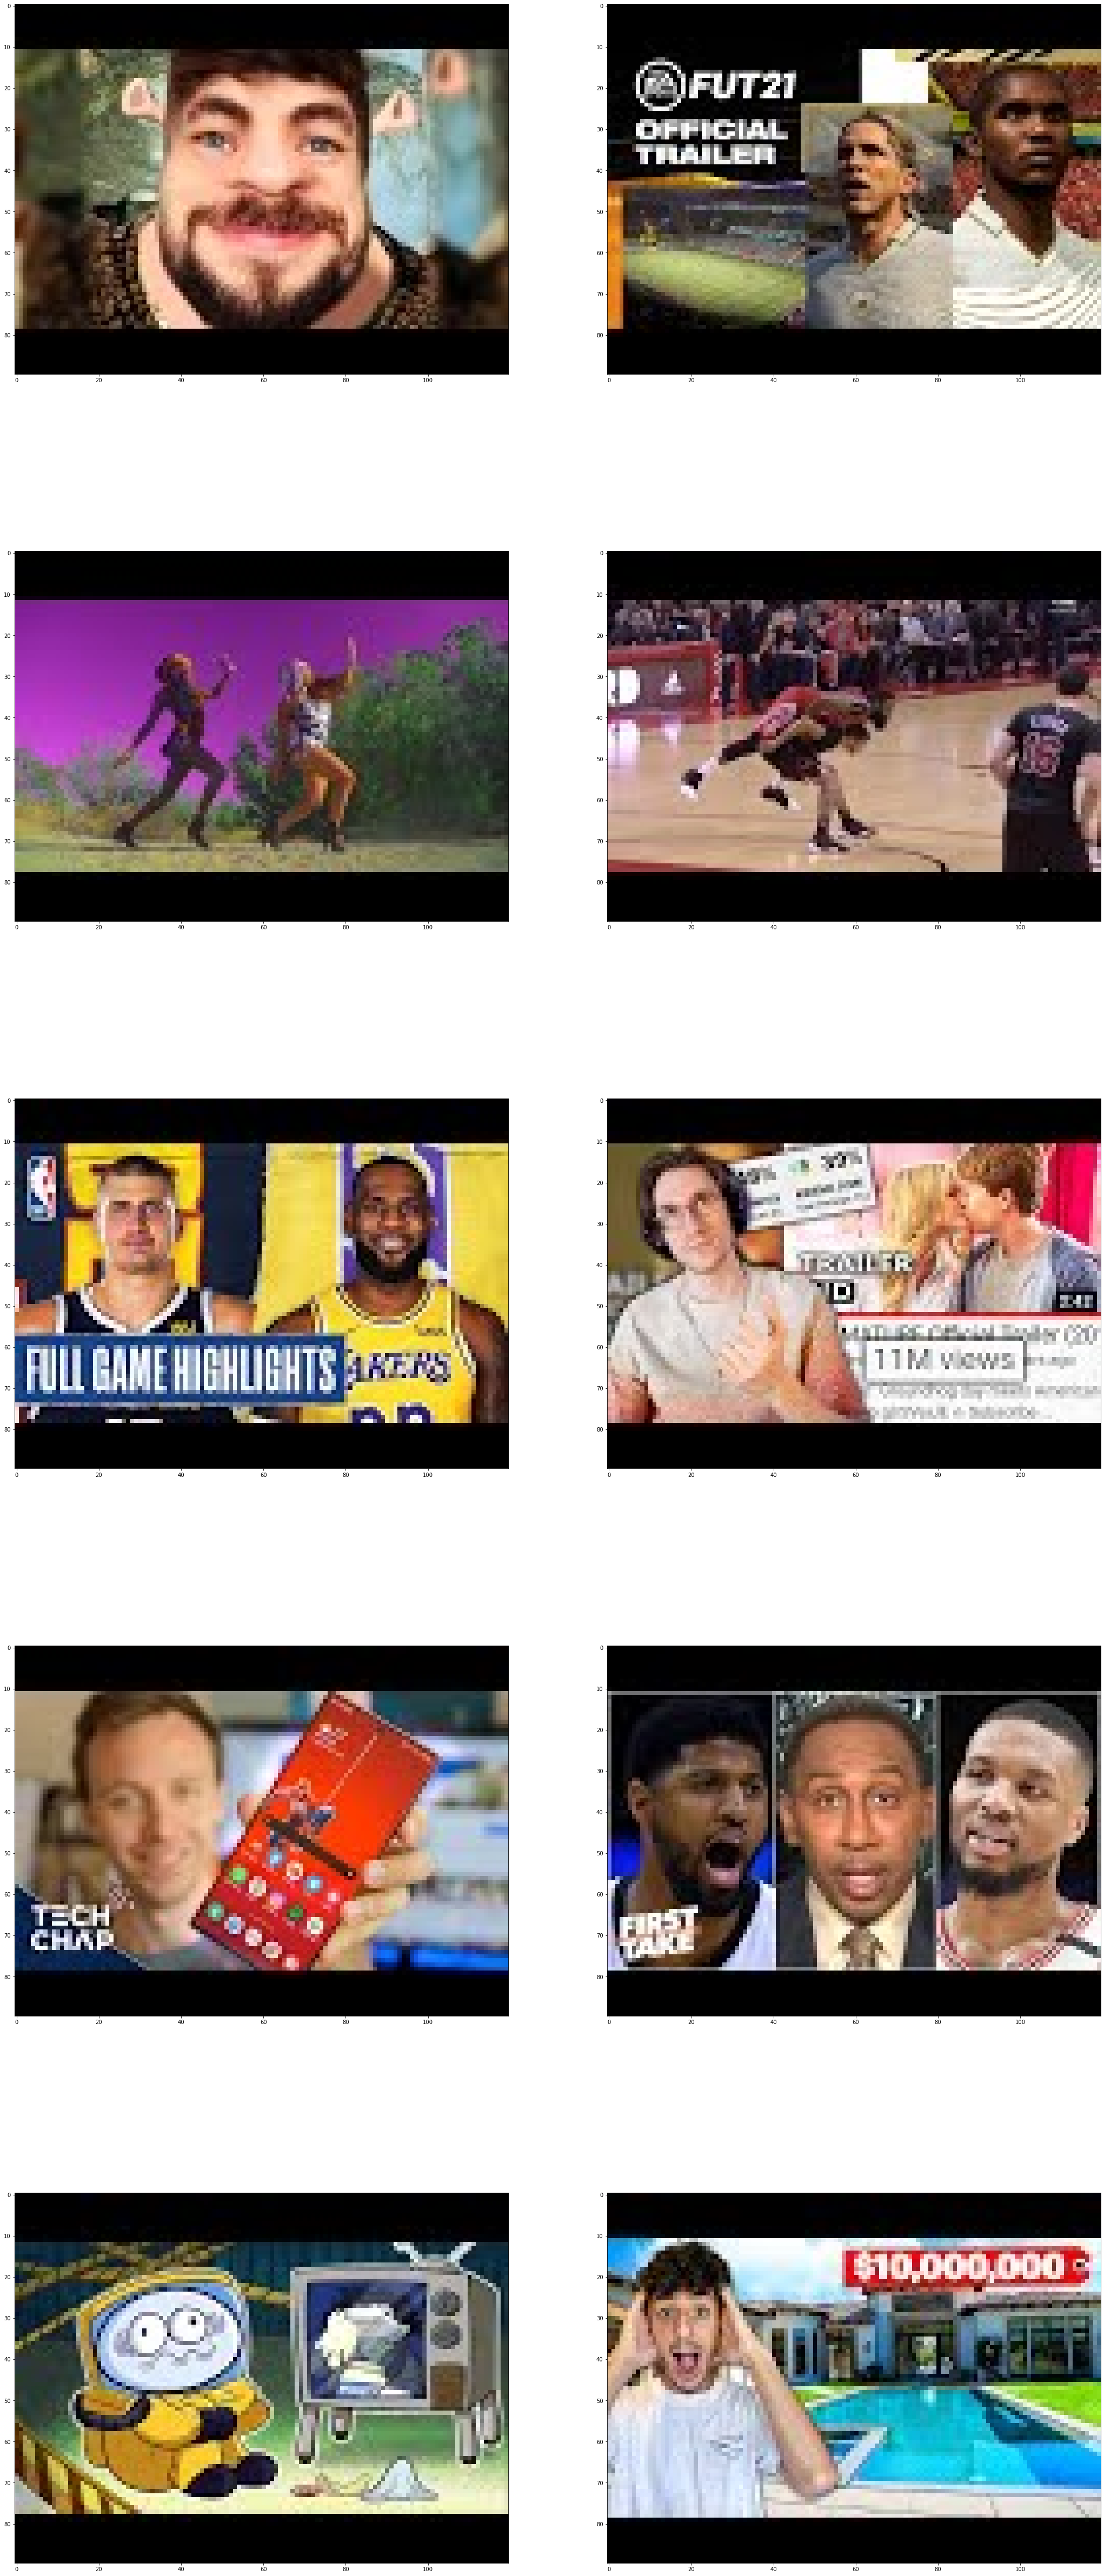

In [67]:
fig, ax=plt.subplots(5, 2, figsize=(2*18, 5*18))
for i in range(10):
    img = images[i]
    ax[i//2][i%2].imshow(img)
plt.show()

In [ ]:
x_size, y_size=2, 20
fig, ax=plt.subplots(y_size, x_size, figsize=(x_size*18, y_size*18))

for i in range(0, y_size*x_size):
    img = images[i]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.06,
        minNeighbors=2,
        flags=cv2.CASCADE_SCALE_IMAGE
    )# For each face
    
    #detector_name = "opencv"
    #detector = deepface.detectors.FaceDetector.build_model(detector_name) #set opencv, ssd, dlib, mtcnn or retinaface
    #obj = deepface.detectors.FaceDetector.detect_faces(detector, detector_name, img)
    #for face in obj:
        #o2 = np.asarray(face[0])
        #plt.imshow(o2)
        #plt.show()
        #analyze = DeepFace.analyze(o2, actions=['age'])
        #print(analyze)
    
    for (x, y, w, h) in faces: 
        # Draw rectangle around the face
        cv2.rectangle(gray, (x, y), (x+w, y+h), (255, 255, 255), 3)
        face = img[x:x+w,y:y+h]
        #analyze = DeepFace.analyze(img[x:x+w,y:y+h]/255, actions=['age'])
        #print(analyze)
    
    ax[i//x_size][i%x_size].imshow(gray, cmap="gray")